# Final Project

## Task 1:

In [2]:
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import deque
import cv2

rgb_image = Image.open('./Dataset_25/Easy/images/000016.png').convert('RGB')
blurred_rgb_image = rgb_image.filter(ImageFilter.GaussianBlur(radius=2))
hsv_image = blurred_rgb_image.convert('HSV')
ground_truth_image = Image.open('./Dataset_25/Easy/masks/000016.png').convert('L')

bgr_image = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2BGR)

### Colour Thresholding: Hue Channel only

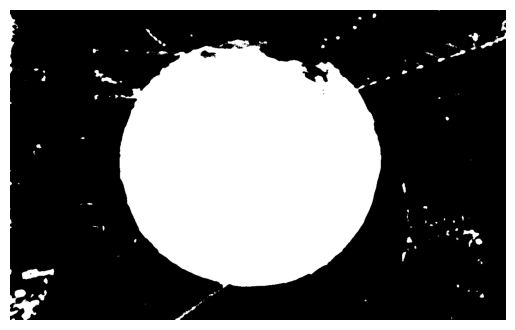

In [3]:
def threshoding(hsv_image: Image.Image, hue_threshold: list, saturation_threshold: int = 0) -> np.ndarray:
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)

    hue_channel = hsv_array[:, :, 0]
    saturation_channel = hsv_array[:, :, 1]
    mask = (hue_channel >= hue_threshold[0]) & (hue_channel <= hue_threshold[1]) & (saturation_channel >= saturation_threshold)
    binary_image = np.zeros_like(hue_channel)
    binary_image[mask] = 255

    return binary_image

threshoding_mask = threshoding(hsv_image=hsv_image, hue_threshold=[120, 360])
plt.imshow(threshoding_mask, cmap='gray')
plt.axis('off')
plt.show()

### Colour Thresholding: Hue + Saturation + Value

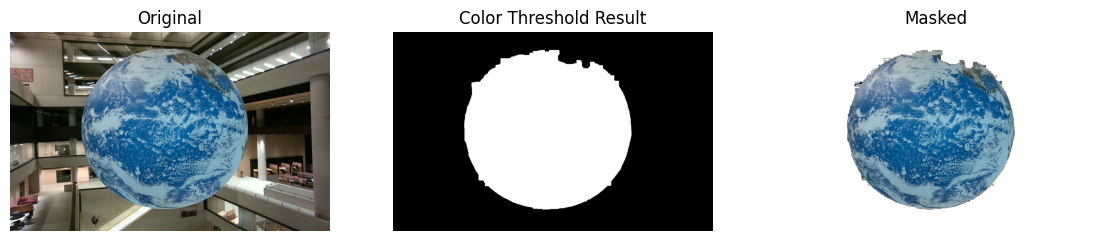

In [4]:
def crop_with_mask(img, mask, box):
    (x1, y1, x2, y2) = box

    # Crop image + crop mask
    cropped = img[y1:y2, x1:x2]
    mask_crop = mask[y1:y2, x1:x2]

    # White background outside the mask
    cropped_white = cropped.copy()
    cropped_white[mask_crop == 0] = [255, 255, 255]

    # Place back into white canvas
    canvas = np.ones_like(img) * 255
    canvas[y1:y2, x1:x2] = cropped_white

    return canvas

def color_threshold_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([55, 15, 40])
    upper_blue = np.array([150, 255, 210])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_white = np.array([90, 5, 180])
    upper_white = np.array([100, 15, 190])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    mask = cv2.bitwise_or(mask_blue, mask_white)

    kernel = np.ones((15, 15), np.uint8)
    mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_clean, connectivity=4)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    earth_mask = (labels == largest_label).astype(np.uint8) * 255

    x, y, w, h, area = stats[largest_label]
    x1, y1 = x, y
    x2, y2 = x + w, y + h

    return earth_mask, (x1, y1, x2, y2)


cropped_mask, box = color_threshold_mask(bgr_image)
canvas = crop_with_mask(bgr_image, cropped_mask, box)


plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Color Threshold Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

### Region Growing

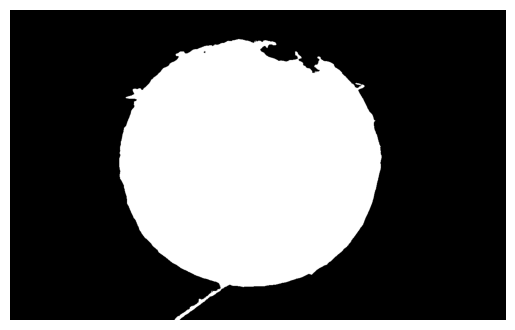

In [5]:
def region_growing(hsv_image: Image.Image, seed_point: tuple, threshold: int):
    # Setup
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)
    hue_channel = hsv_array[:, :, 0]

    if threshold == 0:
        return np.zeros_like(hue_channel)

    seeds = seed_point # Your ocean seed
    connectivity = 4 # or 8
    flags = connectivity | (255 << 8) | cv2.FLOODFILL_FIXED_RANGE
    
    # floodFill expects a numpy array. 
    # We work on the Hue channel directly.
    # Note: cv2.floodFill modifies the image in-place, so we copy.
    work_image = hue_channel.copy()
    
    h, w = work_image.shape
    mask = np.zeros((h+2, w+2), np.uint8) # floodFill requires mask to be 2px larger
    
    # Run Region Growing (Instant in C++)
    # For 1-channel image, newVal is a scalar, loDiff/upDiff are scalars.
    cv2.floodFill(work_image, mask, seeds, 255, (threshold,), (threshold,), flags)
    
    # Extract the actual binary map (Crop the 2px border)
    binary_output = mask[1:-1, 1:-1]

    return binary_output

region_growing_mask = region_growing(hsv_image=hsv_image, seed_point=(500, 500), threshold=50)
plt.imshow(region_growing_mask, cmap='gray')
plt.axis('off')
plt.show()

### Hough Circle Detection

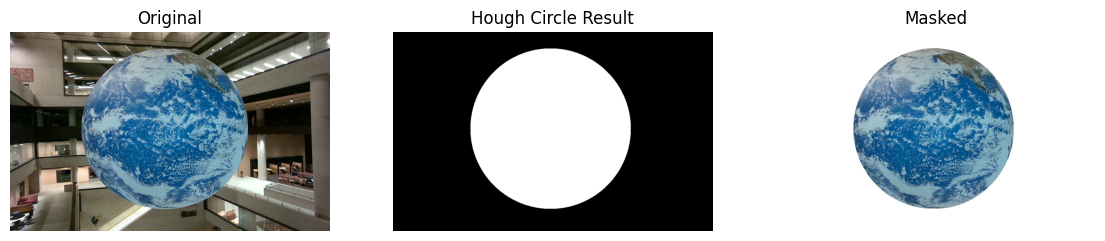

In [6]:
def hough_circle_mask(img, min_radius=300, max_radius=400):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=100,
        param1=50,
        param2=30,
        minRadius=min_radius,
        maxRadius=max_radius
    )

    # Create empty mask
    mask = np.zeros_like(gray)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]

        # Draw mask
        cv2.circle(mask, (x, y), r, 255, -1)

        # Bounding box
        x1 = max(x - r, 0)
        y1 = max(y - r, 0)
        x2 = min(x + r, img.shape[1])
        y2 = min(y + r, img.shape[0])

    else:
        # No circle found → return full white?
        mask[:] = 0
        x1, y1, x2, y2 = 0, 0, img.shape[1], img.shape[0]

    return mask, (x1, y1, x2, y2)


cropped_mask, box = hough_circle_mask(bgr_image)
canvas = crop_with_mask(bgr_image, cropped_mask, box)

plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")


plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("Hough Circle Result")
plt.axis("off")


plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

### Ransac Circle Detection

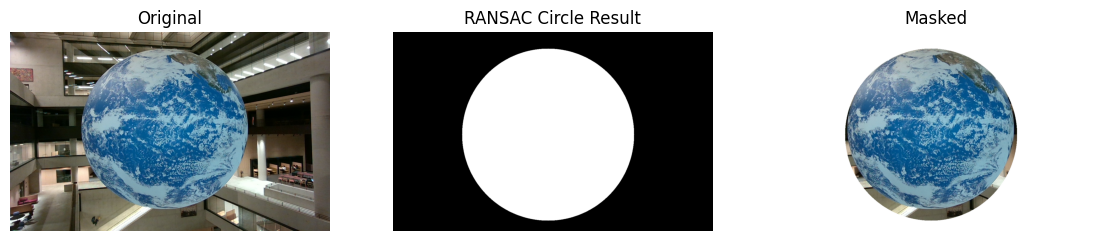

In [7]:
def get_circle_from_3_points(p1, p2, p3):
    """
    Mathematical helper to find (cx, cy, r) from 3 points.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    
    if abs(D) < 1e-7: # Points are collinear (straight line)
        return None
        
    center_x = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    center_y = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    radius = np.sqrt((center_x - x1)**2 + (center_y - y1)**2)
    
    return (center_x, center_y, radius)

def fit_circle_ransac(img, max_iterations=2000, distance_threshold=2.0):
    """
    Fits a circle to the edge points of an image using RANSAC.
    
    img: Input image (RGB or BGR or Gray)
    """
    # Convert PIL to Numpy if needed
    if isinstance(img, Image.Image):
        img = np.array(img)
        # PIL is RGB, OpenCV expects BGR usually.
        # We will convert to Gray anyway.
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif isinstance(img, np.ndarray):
        if len(img.shape) == 3:
            # Assume BGR if numpy array (standard OpenCV)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
    else:
        return None, None

    # Edge detection to find points
    edges = cv2.Canny(gray, 100, 200)
    
    # Get coordinates of edge points
    # np.where returns (row, col) -> (y, x)
    y_coords, x_coords = np.where(edges > 0)
    points = np.column_stack((x_coords, y_coords))
    
    if len(points) < 3:
        print("Not enough points for RANSAC")
        return np.zeros_like(gray), (0, 0, 0, 0)

    best_circle = None
    max_inliers = 0
    
    # RANSAC Loop
    for i in range(max_iterations):
        # A. Pick 3 random points
        sample_indices = np.random.choice(len(points), 3, replace=False)
        p1, p2, p3 = points[sample_indices]
        
        # B. Calculate Circle from 3 points
        temp_circle = get_circle_from_3_points(p1, p2, p3)
        
        if temp_circle is None: continue 
        
        cx, cy, r = temp_circle
        
        # Filter circles that are too small or too large
        if r > max(gray.shape) or r < 50: 
            continue
            
        # Check if center is somewhat within image bounds
        if not (-r < cx < gray.shape[1] + r and -r < cy < gray.shape[0] + r):
            continue

        # C. Calculate distances of ALL points to this circle center
        dists = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
        
        # D. Count Inliers
        error = np.abs(dists - r)
        inliers_count = np.count_nonzero(error < distance_threshold)
        
        # E. Keep the best model
        if inliers_count > max_inliers:
            max_inliers = inliers_count
            best_circle = (cx, cy, r)
            
    # Create mask and bbox
    mask = np.zeros_like(gray)
    bbox = (0, 0, gray.shape[1], gray.shape[0])
    
    if best_circle:
        cx, cy, r = best_circle
        cv2.circle(mask, (int(cx), int(cy)), int(r), 255, -1)
        
        x1 = int(max(cx - r, 0))
        y1 = int(max(cy - r, 0))
        x2 = int(min(cx + r, gray.shape[1]))
        y2 = int(min(cy + r, gray.shape[0]))
        bbox = (x1, y1, x2, y2)
        
    return mask, bbox

# Update the usage to match other examples
cropped_mask, box = fit_circle_ransac(blurred_rgb_image)
canvas = crop_with_mask(bgr_image, cropped_mask, box)

plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB))
plt.title("RANSAC Circle Result")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")

plt.show()

### Colour Thresholding + Region Growing

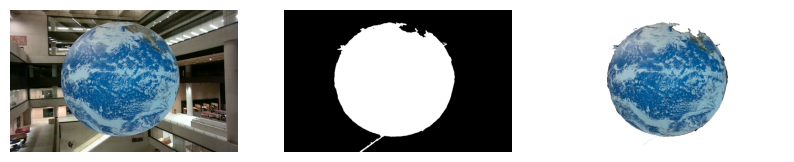

In [8]:
def threshold_and_region_growing(hsv_image: Image.Image, rg_threshold: int, saturation_threshold: int = 120):
    binary_seeds = threshoding(hsv_image, hue_threshold=[140, 190], saturation_threshold=saturation_threshold)
    # plt.figure(figsize=(10,5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(binary_seeds, cmap='gray')
    # plt.axis('off')
    # plt.title('Safe Seeds')
    # plt.savefig('safe_ocean_seeds.png')


    segmented_images = []
    for y in range(0, binary_seeds.shape[0], 50):
        for x in range(0, binary_seeds.shape[1], 50):
            if binary_seeds[y, x] == 255:
                # print(f"Seed found at: ({x}, {y})")
                segmented_image = region_growing(hsv_image, seed_point=(x, y), threshold=rg_threshold)
                segmented_images.append(segmented_image)
    # Combine all segmented images
    combined_segmented_image = np.zeros_like(binary_seeds)
    for seg_img in segmented_images:
        combined_segmented_image = np.maximum(combined_segmented_image, seg_img)
    # plt.imshow(combined_segmented_image, cmap='gray')
    # plt.axis('off')
    # plt.show()

    return combined_segmented_image


mask = threshold_and_region_growing(hsv_image=hsv_image, rg_threshold=50, saturation_threshold=120)
canvas = crop_with_mask(bgr_image, mask, box)

plt.figure(figsize=(10,6))
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Threshoding + Region Growing + Ransac Circle Detection

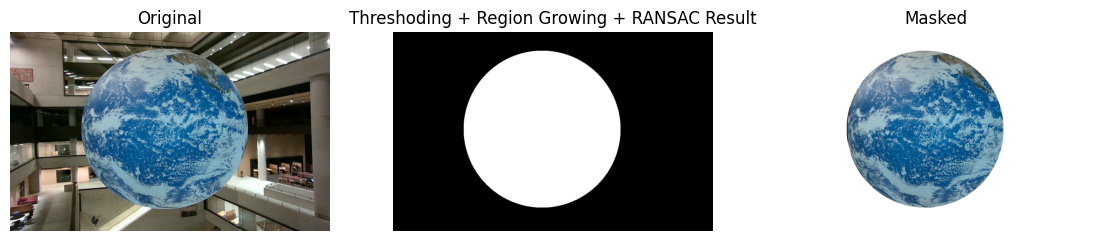

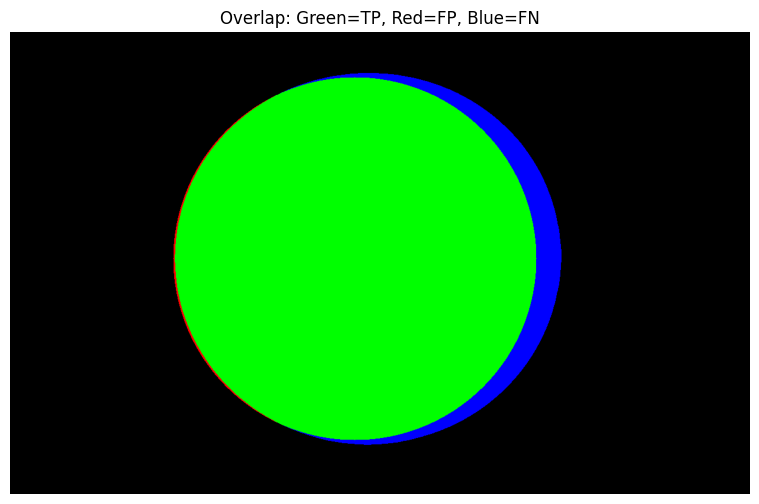

In [18]:
threshoding_region_growing_mask = threshold_and_region_growing(hsv_image=hsv_image, rg_threshold=50, saturation_threshold=120)

ransac_mask, box = fit_circle_ransac(threshoding_region_growing_mask)
canvas = crop_with_mask(bgr_image, ransac_mask, box)

plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
plt.imshow(rgb_image)
plt.title("Original")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(ransac_mask, cv2.COLOR_BGR2RGB))
plt.title("Threshoding + Region Growing + RANSAC Result")
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Masked")
plt.axis("off")
plt.show()

# Overlap Visualization
def visualize_overlap(ground_truth, prediction):
    gt_array = np.array(ground_truth)
    # Ensure binary (0 or 255)
    gt_array = (gt_array > 127).astype(np.uint8) * 255
    pred_array = (prediction > 127).astype(np.uint8) * 255
    
    # Create an RGB image for visualization
    h, w = gt_array.shape
    overlap_img = np.zeros((h, w, 3), dtype=np.uint8)
    
    # True Positive (Green) - Both are 255
    tp_mask = (gt_array == 255) & (pred_array == 255)
    # False Positive (Red) - Pred is 255, GT is 0
    fp_mask = (gt_array == 0) & (pred_array == 255)
    # False Negative (Blue) - GT is 255, Pred is 0
    fn_mask = (gt_array == 255) & (pred_array == 0)
    
    # Assign colors
    overlap_img[tp_mask] = [0, 255, 0]   # Green for correct
    overlap_img[fp_mask] = [255, 0, 0]   # Red for extra
    overlap_img[fn_mask] = [0, 0, 255]   # Blue for missed
    
    plt.figure(figsize=(10, 6))
    plt.imshow(overlap_img)
    plt.title("Overlap: Green=TP, Red=FP, Blue=FN")
    plt.axis('off')
    plt.show()

visualize_overlap(ground_truth_image, ransac_mask)

### ROC Curve

RANSAC ROC: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


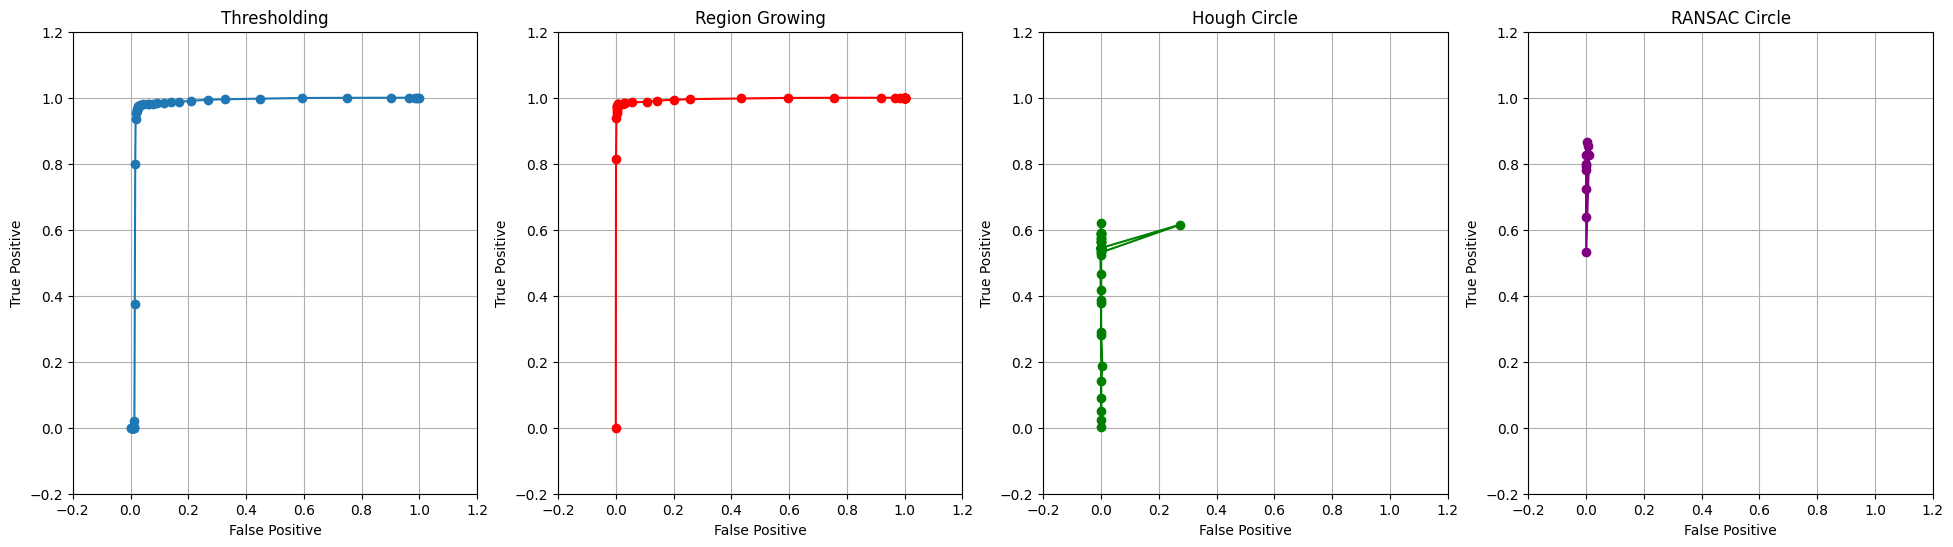

In [ ]:
def draw_roc_curve(image: Image.Image, ground_truth_image: Image.Image, bgr_image):
    gt_array = np.array(ground_truth_image)
    blurred_image = image.copy().filter(ImageFilter.GaussianBlur(radius=2))
    hsv_img = blurred_image.convert("HSV")

    true_positive_thresholding = []
    true_negative_thresholding = []
    false_positive_thresholding = []
    false_negative_thresholding = []
    thresholds = range(0, 256, 5)

    for thresh in tqdm(thresholds, desc="Thresholding ROC"):
        binary_image = threshoding(hsv_img, hue_threshold=[thresh, 255], saturation_threshold=0)
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        true_positive_thresholding.append(tp)
        false_positive_thresholding.append(fp)
        true_negative_thresholding.append(tn)
        false_negative_thresholding.append(fn)
    
    true_positive_rate_thresholding = np.array(true_positive_thresholding) / (np.array(true_positive_thresholding) + np.array(false_negative_thresholding) + 1e-6)
    false_positive_rate_thresholding = np.array(false_positive_thresholding) / (np.array(false_positive_thresholding) + np.array(true_negative_thresholding) + 1e-6)

    plt.figure(figsize=(24,6))
    plt.subplot(1, 4, 1)
    plt.plot(false_positive_rate_thresholding, true_positive_rate_thresholding, marker='o')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Thresholding')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.grid()

    tp_region_growing = []
    tn_region_growing = []
    fp_region_growing = []
    fn_region_growing = []
    thresholds = range(0, 257, 5)
    seed_point = (500, 500)  # Example seed point
    blurred_image = image.copy().filter(ImageFilter.GaussianBlur(radius=2))
    hsv_img = blurred_image.convert("HSV")
    for thresh in tqdm(thresholds, desc="Region Growing ROC"):
        binary_image = region_growing(hsv_img, seed_point=seed_point, threshold=thresh)
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        tp_region_growing.append(tp)
        fp_region_growing.append(fp)
        tn_region_growing.append(tn)
        fn_region_growing.append(fn)
    
    true_positive_rate_region_growing = np.array(tp_region_growing) / (np.array(tp_region_growing) + np.array(fn_region_growing) + 1e-6)
    false_positive_rate_region_growing = np.array(fp_region_growing) / (np.array(fp_region_growing) + np.array(tn_region_growing) + 1e-6)

    plt.subplot(1, 4, 2)
    plt.plot(false_positive_rate_region_growing, true_positive_rate_region_growing, marker='o', color='red')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Region Growing')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.grid()



    tp_hough = []
    tn_hough = []
    fp_hough = []
    fn_hough = []

    # Vary param2 from high (strict) to low (loose)
    # Include 0 to force all-white mask
    hough_thresholds = list(range(0, 1000, 25))

    for thresh in tqdm(hough_thresholds, desc="Hough Circle ROC"):
        # We use the global bgr_image here as hough_circle_mask expects a BGR numpy array
        binary_image, _ = hough_circle_mask(bgr_image, min_radius=0, max_radius=thresh)
        
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        
        tp_hough.append(tp)
        fp_hough.append(fp)
        tn_hough.append(tn)
        fn_hough.append(fn)

    true_positive_rate_hough = np.array(tp_hough) / (np.array(tp_hough) + np.array(fn_hough) + 1e-6)
    false_positive_rate_hough = np.array(fp_hough) / (np.array(fp_hough) + np.array(tn_hough) + 1e-6)

    plt.subplot(1, 4, 3)
    plt.plot(false_positive_rate_hough, true_positive_rate_hough, marker='o', color='green')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Hough Circle')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.grid()

    # RANSAC ROC
    tp_ransac = []
    tn_ransac = []
    fp_ransac = []
    fn_ransac = []
    
    # Vary distance_threshold
    ransac_thresholds = np.linspace(0.0, 100, 50)

    for thresh in tqdm(ransac_thresholds, desc="RANSAC ROC"):
        binary_image, _ = fit_circle_ransac(bgr_image, max_iterations=500, distance_threshold=thresh)
        
        tp = np.sum((binary_image == 255) & (gt_array == 255))
        tn = np.sum((binary_image == 0) & (gt_array == 0))
        fp = np.sum((binary_image == 255) & (gt_array == 0))
        fn = np.sum((binary_image == 0) & (gt_array == 255))
        
        tp_ransac.append(tp)
        fp_ransac.append(fp)
        tn_ransac.append(tn)
        fn_ransac.append(fn)

    true_positive_rate_ransac = np.array(tp_ransac) / (np.array(tp_ransac) + np.array(fn_ransac) + 1e-6)
    false_positive_rate_ransac = np.array(fp_ransac) / (np.array(fp_ransac) + np.array(tn_ransac) + 1e-6)

    plt.subplot(1, 4, 4)
    plt.plot(false_positive_rate_ransac, true_positive_rate_ransac, marker='o', color='purple')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('RANSAC Circle')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.grid()

    plt.show()

    # # plotting all curves together
    # plt.plot(false_positive_rate_thresholding, true_positive_rate_thresholding, marker='.', color='blue', label='Thresholding')
    # plt.plot(false_positive_rate_region_growing, true_positive_rate_region_growing, marker='.', color='red', label='Region Growing')
    # plt.plot(false_positive_rate_hough, true_positive_rate_hough, marker='.', color='green', label='Hough Circle')
    # plt.plot(false_positive_rate_ransac, true_positive_rate_ransac, marker='.', color='purple', label='RANSAC Circle')
    # plt.xlabel('False Positive')
    # plt.ylabel('True Positive')
    # plt.title('ROC Curve Comparison')
    # plt.legend()
    # plt.grid()
    # plt.show()

draw_roc_curve(rgb_image, ground_truth_image, bgr_image)

### Youden's J Index Evaluation

100%|██████████| 26/26 [01:12<00:00,  2.79s/it]


Best Youden's J Index: 0.972180491021369 at Saturation: 90, Threshold: 60
Heatmap saved as 'youdens_j_heatmap.png'


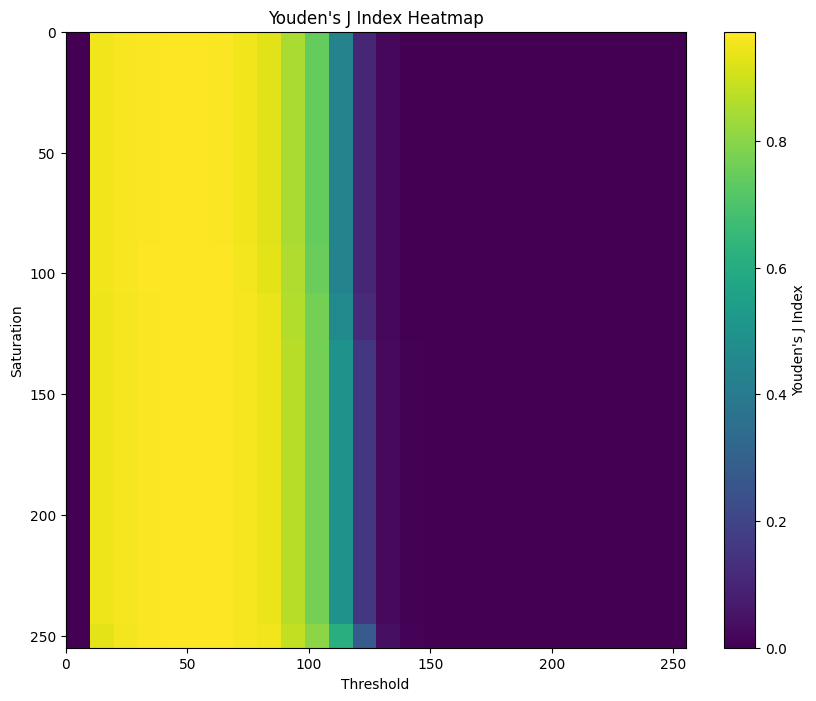

In [ ]:
def YoudensJ_evaluation(hsv_img: Image.Image, ground_truth_image: Image.Image):
    gt_array = np.array(ground_truth_image)

    saturations = range(0, 256, 10)
    thresholds = range(0, 256, 10)
    
    heatmap_data = np.zeros((len(saturations), len(thresholds)))

    best_jouden_index = -1
    best_saturation = -1
    best_region_growing_threshold = -1
    
    for i, sat in tqdm(enumerate(saturations), total=len(saturations)):
        for j, thresh in enumerate(thresholds):
            binary_image = threshold_and_region_growing(hsv_img, rg_threshold=thresh, saturation_threshold=sat)
            tp = np.sum((binary_image == 255) & (gt_array == 255))
            tn = np.sum((binary_image == 0) & (gt_array == 0))
            fp = np.sum((binary_image == 255) & (gt_array == 0))
            fn = np.sum((binary_image == 0) & (gt_array == 255))

            tpr = tp / (tp + fn + 1e-6)
            fpr = fp / (fp + tn + 1e-6)

            jouden_index = tpr - fpr
            heatmap_data[i, j] = jouden_index

            if jouden_index > best_jouden_index:
                best_jouden_index = jouden_index
                best_saturation = sat
                best_region_growing_threshold = thresh
    
    print(f"Best Youden's J Index: {best_jouden_index} at Saturation: {best_saturation}, Region Growing Threshold: {best_region_growing_threshold}")

    plt.figure(figsize=(10, 8))
    # extent=[x_min, x_max, y_max, y_min] to match image coordinates (y going down)
    # x is threshold, y is saturation
    plt.imshow(heatmap_data, extent=[0, 255, 255, 0], aspect='auto', cmap='viridis')
    plt.colorbar(label="Youden's J Index")
    plt.xlabel('Threshold')
    plt.ylabel('Saturation')
    plt.title("Youden's J Index Heatmap")
    plt.savefig('youdens_j_heatmap.png')
    print("Heatmap saved as 'youdens_j_heatmap.png'")
    plt.show()

    return best_jouden_index, best_saturation, best_region_growing_threshold

best_jouden_index, best_saturation, best_region_growing_threshold = YoudensJ_evaluation(hsv_image, ground_truth_image)

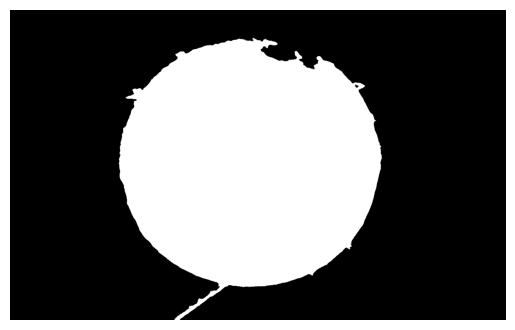

In [12]:
best_mask = threshold_and_region_growing(hsv_image=hsv_image, rg_threshold=best_region_growing_threshold, saturation_threshold=best_saturation)
plt.imshow(best_mask, cmap='gray')
plt.axis('off')
plt.show()